# Test Dataset to check

In [167]:
import multiprocessing

NUM_PROCESSORS=multiprocessing.cpu_count()
#print("Cpu count: ",NUM_PROCESSORS)

In [168]:
#as it turned out interactive shell (like Jupyter cannot handle CPU multiprocessing well so check which medium the code is runing)
#we will write code in Jupyter for understanding purposes but final execuation will be in shell
from ipynb.fs.full.Utils import isnotebook
from ipynb.fs.full.Dataset import get_data, generate_synthetic
from torch_geometric.utils import to_networkx, from_networkx
import torch_geometric.utils.homophily as homophily
import copy

In [169]:
import torch
import torch.nn as nn
from torch_sparse import SparseTensor
from tqdm import tqdm
import math
import time
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset

In [170]:
import random
random.seed(12345)
import numpy as np
np.random.seed(12345)

In [171]:
import heapq
import sklearn
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels

In [172]:
from joblib import Parallel, delayed
from multiprocessing.pool import ThreadPool, Pool

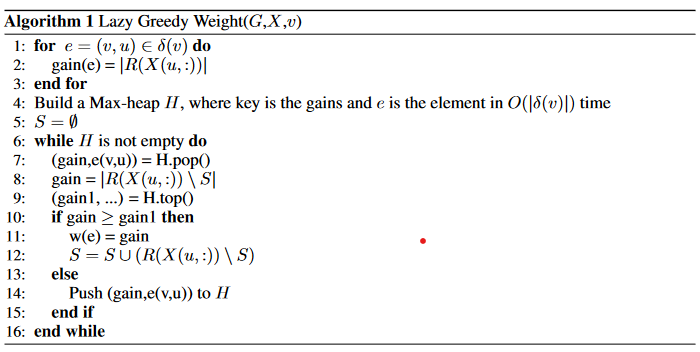

In [173]:
import argparse
from argparse import ArgumentParser
from ipynb.fs.full.Dataset import get_data
from ipynb.fs.full.Dataset import datasets as available_datasets

#set default arguments here
def get_configuration():
    parser = ArgumentParser()    
    parser.add_argument('--log_info', type=bool, default=True)
    parser.add_argument('--pbar', type=bool, default=False)
    parser.add_argument('--num_worker', type=int, default=0)
    parser.add_argument('--dataset', type=str, default="karate", choices=available_datasets)
    parser.add_argument('-f') ##dummy for jupyternotebook
    args = parser.parse_args()
    
    dict_args = vars(args)
    
    return args, dict_args

args, dict_args = get_configuration()

In [174]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy.sparse import csr_matrix
import numpy
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KNeighborsTransformer

In [175]:
def calculate_pairwise_distances(X, Y=None, metric='precomputed', n_neighbors=None):
    if metric in ('precomputed', 'ignore'):
        return X

    if n_neighbors is None:
        if metric == 'euclidean':
            X_pairwise = pairwise_distances(X, Y=Y, metric=metric, squared=True)
        elif metric == 'correlation' or metric == 'cosine':
            # An in-place version of:
            # X_pairwise = 1 - (1 - pairwise_distances(X, metric=metric)) ** 2
            
            X_pairwise = pairwise_distances(X, Y=Y, metric=metric)
            X_pairwise = numpy.subtract(1, X_pairwise, out=X_pairwise)
            X_pairwise = numpy.square(X_pairwise, out=X_pairwise)
            X_pairwise = numpy.subtract(1, X_pairwise, out=X_pairwise)
        else:
            X_pairwise = pairwise_distances(X, Y=Y, metric=metric)
    else:
        if metric == 'correlation' or metric == 'cosine':
            # An in-place version of:
            # X = 1 - (1 - pairwise_distances(X, metric=metric)) ** 2

            X = pairwise_distances(X, Y=Y, metric=metric)
            X = numpy.subtract(1, X, out=X)
            X = numpy.square(X, out=X)
            X = numpy.subtract(1, X, out=X)
            metric = 'precomputed'

        if isinstance(n_neighbors, int):
            X_pairwise = KNeighborsTransformer(
                n_neighbors=n_neighbors, metric=metric
                ).fit_transform(X)

        elif isinstance(n_neighbors, KNeighborsTransformer):
            X_pairwise = n_neighbors.fit_transform(X)

    if metric == 'correlation' or metric == 'cosine':
        if isinstance(X_pairwise, csr_matrix):
            X_pairwise.data = numpy.subtract(1, X_pairwise.data, 
                out=X_pairwise.data)
        else:
            X_pairwise = numpy.subtract(1, X_pairwise,
                out=X_pairwise)
    else:
        if isinstance(X_pairwise, csr_matrix):
            X_pairwise.data = numpy.subtract(X_pairwise.max(),
                X_pairwise.data, out=X_pairwise.data)
        else:
            X_pairwise = numpy.subtract(X_pairwise.max(), X_pairwise,
                out=X_pairwise)

    return X_pairwise

In [176]:
# #X =np.array([[0,0],[0.8,0.0],[0.2,0.6]])
# X =np.array([[0,0],
#              [0.8,0.0],
#              [0.2,0.6],
#              [1.2,0.2],
#              [0.8,0.4]])
# kernel_dist = calculate_pairwise_distances(X, metric='euclidean')
# print(kernel_dist)
# data = Data(x = X, edge_index=torch.LongTensor([[0,1],[0,2],[0,3],[0,4]]).T,num_nodes=5)
# data

## SubModular Weight Facility Faster implementation

In [177]:
class SubModularWeightFacilityFaster():
    
    def __init__(self, data, sub_func='facility', metric='cosine', log = True, lambda1=0.25, lambda2=0.25, w1=1.0, w2=0.5, w3=0.1):
        
        self.N = N = data.num_nodes
        self.E = E = data.num_edges
        self.data = data
        self.log = log

        self.adj = SparseTensor(
            row=data.edge_index[0], col=data.edge_index[1],
            value=torch.arange(E, device=data.edge_index.device),
            sparse_sizes=(N, N))
        
        self.lambda1=lambda1
        self.lambda2=lambda2
        self.w1=w1
        self.w2=w2
        self.w3=w3
        
        if self.log:
            print("Metric: ", metric)
        
        self.metric = metric            
        
    def lazy_greedy_weight(self,u):
    
        row, col, edge_index = self.adj[u,:].coo()
        
        if len(col)==0:
            return [],[]
                
        vertices = [u]+col.tolist()
        
        v2i={i:j for i,j in zip(vertices, range(len(vertices)))}
        i2v={value:key for key, value in v2i.items()}
                    
        kernel_dist = calculate_pairwise_distances(self.data.x[vertices], metric=self.metric)
                
#         print(vertices)
#         print(row,col,edge_index)
#         print(self.data.x[vertices])
#         print(kernel_dist) 
        
        #convert to max heap by multiplying with -1
        gain_of_u = np.sum(kernel_dist[v2i[u],:])
        gain_list=[(-1*(sum(np.max(kernel_dist[[v2i[u],v2i[v.item()]],:],axis=0))-gain_of_u),v.item(), e.item()) for v,e in zip(col,edge_index)] 
        
#         print(gain_of_u)
#         print(gain_list)

        heapq.heapify(gain_list)
        #print(gain_list)
        
        S=[u]
        S_G=[]
        S_edge=[]
        S_index=[v2i[u]]
                        
        lambda1 = self.lambda1 #top 25% with probability 1
        lambda2 = self.lambda2 #second 25% with probability 0.5         
        l1=math.ceil(len(col)*lambda1)
        l2=min(len(col)-l1,math.ceil(len(col)*lambda2))
        l3=max(0,int(len(col)-l1-l2))
        
        #print(len(col),l1, l2, l3)
        
        rank=1 #rank weight instead gain weight
        
        S_index_gain=gain_of_u
        
        while(gain_list):
            (gain_v, v, e) = heapq.heappop(gain_list)
            gain_v = -1*gain_v #make it positive
            
            #print("popped: ",gain_v, v)                        

            if len(gain_list)==0:                                    
                S.append(v)
                if gain_v<1e-6:
                    gain_v=1e-6#S_G.append(gain_v)#S_G.append(rank)
                                        
                if rank <= l1:S_G.append(self.w1)                
                elif rank<=l1+l2:S_G.append(self.w2)
                else:S_G.append(self.w3)

                rank+=1                
                S_edge.append(e)
                S_index.append(v2i[v])
                break
                
            elif len(gain_list)<l3:
                S.append(v)
                S_G.append(self.w3)
                rank+=1                
                S_edge.append(e)
                S_index.append(v2i[v])
                continue
                
            gain_v_update = sum(np.max(kernel_dist[np.append(S_index,v2i[v]),:],axis=0))-S_index_gain
            
            #print("updated: ",gain_v_update, S_index_gain)
                    
            #print("updated: ", S,v,gain_v_update, gain_v)
            (gain_v_second,v_second,_)=gain_list[0] #top
            gain_v_second = -1*gain_v_second #make it positive

            if gain_v_update>=gain_v_second:                
                if gain_v_update<1e-6:
                    gain_v_update=1e-6
                    
                gain_v_update = -1*gain_v_update    
                
                S.append(v)
                #S_G.append(gain_v_update)
                #S_G.append(rank)
                S_index_gain = sum(np.max(kernel_dist[np.append(S_index,v2i[v]),:],axis=0))
                                
                
                    
                if rank<=l1:S_G.append(self.w1)
                elif rank<=l1+l2:S_G.append(self.w2)
                else:S_G.append(self.w3)
                rank+=1                
                S_edge.append(e)
                S_index.append(v2i[v])
                
                #print("Taken: ", S_index, S_index_gain)
                
            else:
                heapq.heappush(gain_list,(-1*gain_v_update,v, e))            
    
        return S_G, S_edge
    
    
        #serial
    def get_submodular_weight(self):
        
        N = self.N
        #N = 1000
        
        if self.log:
            pbar = tqdm(total=N)
            pbar.set_description(f'Nodes')

        edge_weight=[]
        edge_index=[]
        
        test = 0

        for u in range(N):                
            weight, e_index = self.lazy_greedy_weight(u)
            edge_weight.extend(weight)
            edge_index.extend(e_index)
        
            #test += sum((np.array(weight)>1.0).astype(int))
            if self.log:
                pbar.update(1)
        
        #print(test)
        if self.log:
            pbar.close()
        
        assert len(edge_index)==self.E        
        
        weight=torch.zeros(len(edge_index))        
        weight[edge_index]=torch.Tensor(edge_weight)
        
        return weight
        
    
    def process_block(self, list_u):
        
        #print("Processing :",len(list_u), list_u[0], list_u[-1])
        
        edge_weight = []
        edge_index = []
        
        for u in list_u:        
            weight, e_index = self.lazy_greedy_weight(u)            
            edge_weight.extend(weight)
            edge_index.extend(e_index)
            
        #print("Done :",len(list_u), list_u[0], list_u[-1])
            
        return edge_weight, edge_index, len(list_u)
            
    #multiprocessing
    def get_submodular_weight_multiproces(self):
        
        edge_weight=[]
        edge_index=[]        
        
        N = self.N
        num_blocks = NUM_PROCESSORS
        elem_size = int(N/num_blocks)
        

        nodes = np.arange(num_blocks*elem_size).reshape(num_blocks,-1).tolist()
        if num_blocks*elem_size<N:
            nodes.append(list(range(num_blocks*elem_size,N)))        
        
        pool_size = NUM_PROCESSORS        
        if self.log:
            print("Pool Size: ", pool_size)        
        pool = Pool(pool_size)
        
        if self.log:
            pbar = tqdm(total=N)
            pbar.set_description(f'Nodes')  
                
        for (weight, e_index, num_el) in pool.imap_unordered(self.process_block, nodes):            
            edge_weight.extend(weight)
            edge_index.extend(e_index)
            
            if self.log:
                pbar.update(num_el)
        
        if self.log:
            pbar.close()
        
        assert len(edge_index)==self.E
                
        weight=torch.zeros(len(edge_index))        
        weight[edge_index]=torch.Tensor(edge_weight)        
        
        return weight
    
    
    def compute_weights(self):
        #if isnotebook():
        if self.data.num_nodes<10000:
            weight = self.get_submodular_weight()    
        else:
            weight = self.get_submodular_weight_multiproces()
        
        return weight
        
# submodular_weight = SubModularWeightFacilityFaster(data, metric='cosine')
# S_G, S_edge = submodular_weight.lazy_greedy_weight(0); print(S_G); print(S_edge);

# Test

In [178]:
# data, dataset = get_data('Cora', log=False)
# #data = generate_synthetic(data, d=100, h=0.25, train=0.1, random_state=None, log=False)    
# print(data)

In [179]:
# submodular_weight = SubModularWeightFacilityFaster(data)
# S_G, S_edge = submodular_weight.lazy_greedy_weight(0); print(S_G); print(S_edge);
# #S_G, S_edge = submodular_weight.process_block([0,1,2]); print(S_G); print(S_edge);

## homophily test

In [180]:
def fun():
    
    for d in range(10,11, 10):    
        #d = 25
        h=0.25

        data, dataset = get_data('Cora', log=False)
        data = generate_synthetic(data, d=d, h=h, train=0.1, random_state=None, log=False)

        Nh = homophily(data.edge_index, data.y, method='node')
        Eh = homophily(data.edge_index, data.y, method='edge')
        Einh = homophily(data.edge_index, data.y, method='edge_insensitive')
        E = len(data.edge_index[0])

        submodular_weight = SubModularWeightFacilityFaster(data, metric='cosine')
        data.weight = submodular_weight.compute_weights()

        if 'weight' in data:
            cp_data= copy.deepcopy(data)
            G = to_networkx(cp_data, to_undirected=False, edge_attrs=['weight'])
            to_remove = [(a,b) for a, b, attrs in G.edges(data=True) if attrs["weight"] <1.0 ]
            G.remove_edges_from(to_remove)
            updated_data = from_networkx(G)

            up_E = len(updated_data.edge_index[0])

            up_Nh = homophily(updated_data.edge_index, cp_data.y, method='node')
            up_Eh = homophily(updated_data.edge_index, cp_data.y, method='edge')
            up_Einh = homophily(updated_data.edge_index, cp_data.y, method='edge_insensitive')


        print('{} {} {} {} {} {} {} {} {} {}'.format(d, h, Nh, Eh, Einh, E, up_Nh, up_Eh, up_Einh, up_E))

    return
# fun()

# Main

In [181]:
from torch_geometric.utils import add_self_loops

In [182]:
from torch_scatter import scatter_mean

def my_homophily(edge_index, y):
    row, col = edge_index
    print(row)
    print(col)
    
    out = torch.zeros(row.size(0), device=row.device)
    
    out[y[row] == y[col]] = 1.
    
    print(out)
    
    out = scatter_mean(out, col, 0, dim_size=y.size(0))
    
    print(out)
    
    return float(out.mean())
    

In [183]:
if __name__ == '__main__':  
    
    args.dataset = 'Cora'
    
    data, dataset = get_data(args.dataset, log= False)
#     data = generate_synthetic(data, d=4, h=1.0, train=0.1, random_state=None, log=True, balance = True)
#     #print(data)
    
#     print("Node Homophily:", homophily(data.edge_index, data.y, method='node'))
#     print("Edge Homophily:", homophily(data.edge_index, data.y, method='edge'))
#     print("Edge_insensitive Homophily:", homophily(data.edge_index, data.y, method='edge_insensitive'))    

    submodular_weight = SubModularWeightFacilityFaster(data, metric='cosine', log = True)
#     S_G, S_edge = submodular_weight.lazy_greedy_weight(0); print(S_G); print(S_edge);
    #S_G, S_edge = submodular_weight.process_block([0,1,2]); print(S_G); print(S_edge);

    start = time.time()    
    #data.weight = submodular_weight.compute_weights()
    submodular_weight.get_submodular_weight()    
    end = time.time()
    print("Execution time: ", end-start)
    
#     print(data.edge_index)
#     print(data.weight)
    
#     row, col = data.edge_index
#     data.edge_index = torch.stack((torch.cat((row, col),dim=0), torch.cat((col, row),dim=0)),dim=0)
#     data.weight = torch.cat((data.weight, data.weight),dim=0)
    
#     if 'weight' in data:        
        
#         cp_data= copy.deepcopy(data)
        
#         G = to_networkx(cp_data, to_undirected=False, edge_attrs=['weight'])
#         to_remove = [(a,b) for a, b, attrs in G.edges(data=True) if attrs["weight"] <0.7 ]
#         G.remove_edges_from(to_remove)
        
#         updated_data = from_networkx(G, group_edge_attrs=['weight'])
#         updated_data.weight = updated_data.edge_attr.view(-1)
        
#         row, col = updated_data.edge_index
#         updated_data.edge_index = torch.stack((torch.cat((row, col),dim=0), torch.cat((col, row),dim=0)),dim=0)
#         updated_data.weight = torch.cat((updated_data.weight, updated_data.weight),dim=0)
        
        
# #         print(updated_data)        
# #         print(updated_data.edge_index)
        
# #         N = updated_data.num_nodes
# #         E = updated_data.num_edges
        
# #         adj = SparseTensor(
# #             row=updated_data.edge_index[0], col=updated_data.edge_index[1],
# #             value=torch.arange(E, device=updated_data.edge_index.device),
# #             sparse_sizes=(N, N))
        
# #         for i in range(N):
# #             print("-"*25, i, "-"*25)
# #             row, col, edge_index = adj[i,:].coo()            
# #             print(row, col, edge_index)
# #             print(cp_data.y[col])
# #             print(cp_data.y[i])
        
# #         print(cp_data)
# #         print(updated_data.edge_index.shape)
        
# #         ed, _ = add_self_loops(updated_data.edge_index)
        
# #         print(my_homophily(updated_data.edge_index, cp_data.y))
    
#         print("Node Homophily:", homophily(updated_data.edge_index, cp_data.y, method='node'))
#         print("Edge Homophily:", homophily(updated_data.edge_index, cp_data.y, method='edge'))
#         print("Edge_insensitive Homophily:", homophily(updated_data.edge_index, cp_data.y, method='edge_insensitive'))    
        
    None

Metric:  cosine


Nodes: 100%|██████████| 2708/2708 [00:01<00:00, 1614.99it/s]

Execution time:  1.6791017055511475
